In [1167]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_prominences
from scipy.ndimage import gaussian_filter1d
from scipy.stats import landau

FADC_BIN_WIDTH = 10


In [1168]:
def load_pmt(input_file,pmtname, minnpe = 0.): 
    data=pd.read_csv(input_file, sep ='\t',header=None)
    data.columns = ["num","id", "energy", "pmt1", "pmt2", "pmt3", "pmt4", "pmt1_FADC", "pmt2_FADC", "pmt3_FADC", "pmt4_FADC"]
    pmt_em = data.query("id == 1 or id == 2 or id == -2")[pmtname]
    pmt_mu = data.query("id == 3 or id == -3")[pmtname]

    pmt_mu = np.asarray(pmt_mu[pmt_mu >= minnpe])
    pmt_em = np.asarray(pmt_em[pmt_em >= minnpe])
    pmt_tot = np.concatenate((pmt_mu,pmt_em))
    
    return pmt_em, pmt_mu, pmt_tot

def load_top_sum_fadc_pmt(input_file, minnpe = 0.): 
    data=pd.read_csv(input_file, sep ='\t',header=None)
    data.columns = ["num","id", "energy", "pmt1", "pmt2", "pmt3", "pmt4", "pmt1_FADC", "pmt2_FADC", "pmt3_FADC", "pmt4_FADC"]
    pmt_em_1 = data.query("id == 1 or id == 2 or id == -2")['pmt1_FADC']
    pmt_mu_1 = data.query("id == 3 or id == -3")['pmt1_FADC']
    pmt_em_2 = data.query("id == 1 or id == 2 or id == -2")['pmt2_FADC']
    pmt_mu_2 = data.query("id == 3 or id == -3")['pmt2_FADC']
    pmt_em_3 = data.query("id == 1 or id == 2 or id == -2")['pmt3_FADC']
    pmt_mu_3 = data.query("id == 3 or id == -3")['pmt3_FADC']

    pmt_mu_1 = np.asarray(pmt_mu_1[pmt_mu_1 >= minnpe])
    pmt_em_1 = np.asarray(pmt_em_1[pmt_em_1 >= minnpe])
    pmt_tot_1 = np.concatenate((pmt_mu_1,pmt_em_1))

    pmt_mu_2 = np.asarray(pmt_mu_2[pmt_mu_2 >= minnpe])
    pmt_em_2 = np.asarray(pmt_em_2[pmt_em_2 >= minnpe])
    pmt_tot_2 = np.concatenate((pmt_mu_2,pmt_em_2))

    pmt_mu_3 = np.asarray(pmt_mu_3[pmt_mu_3 >= minnpe])
    pmt_em_3 = np.asarray(pmt_em_3[pmt_em_3 >= minnpe])
    pmt_tot_3 = np.concatenate((pmt_mu_3,pmt_em_3))

    pmt_tot = np.concatenate((pmt_tot_1, pmt_tot_2, pmt_tot_3))
    
    return pmt_tot

In [ ]:

# Gaussian function for fitting
def gaussian(x, A, mu, sigma):
    return A * norm.pdf(x, mu, sigma)

def landau_func(x, A, mu, sigma): 
    return A * landau.pdf(x,mu,sigma)

def pol_2(x, p0, p1, p2): 
    return p0 + p1 * x + p2 * x * x


# Define funciton to perform Gaussian fit of the peak 
fadc_bins = np.arange(0,1000,1)

def gaussian_fit(input_array, fadc_bins, range_low, range_hi, low_count_threshold):

    # Build histogram ignoring low FADC counts (to remove em peak)
    entries, bin = np.histogram(input_array[input_array > low_count_threshold], bins=fadc_bins)
    arg_fadc_muon_mx = np.argmax(entries)
    print('FADC bin with largest entries ',fadc_bins[arg_fadc_muon_mx])

    fadc_low = fadc_bins[arg_fadc_muon_mx] - range_low
    fadc_hi = fadc_bins[arg_fadc_muon_mx] + range_hi

    range = [fadc_low, fadc_hi]

    # Perform fit on histogram with restricted range 
    array_to_fit = input_array[(input_array > fadc_low) & (input_array < fadc_hi)]

    entries_fit, bin_fit = np.histogram(array_to_fit, bins=fadc_bins)
    sigma_entries_fit = np.sqrt(entries_fit)
    sigma_entries_fit[sigma_entries_fit == 0] = 1e-6  # avoid zero division

    bin_centers = (bin_fit[:-1] + bin_fit[1:]) / 2.
    bin_width = bin_fit[1] - bin_fit[0] 

    # First guess for Gaussian parameters 
    p0 = [max(array_to_fit), np.mean(array_to_fit), 2.5*np.std(array_to_fit)]
    print('First guess ',p0)
    bounds = ([0, -np.inf, 1e-6], [np.inf, np.inf, np.inf])

    #array_to_fit = input_array[(input_array > 1.5*np.std(array_to_fit)) & (input_array < 2.5*np.std(array_to_fit))]

    #popt, pcov = curve_fit(gaussian, bin_centers, entries_fit, p0=p0, bounds = bounds, sigma = sigma_entries_fit, absolute_sigma=True)
    popt, pcov = curve_fit(gaussian, bin_centers, entries_fit, p0=p0)

    # Extract parameter estimates
    A_fit, mu_fit, sigma_fit = popt

    # Compute standard errors (uncertainties)
    perr = np.sqrt(np.diag(pcov))
    A_err, mu_err, sigma_err = perr


    return popt, perr, range 


In [1170]:
# Function to find minumum in a range defined by a lower limit and the peak maximum 

def find_valley(input_array, low_threshold, peak_position): 
    print('Looking for minimum between ',low_threshold,' and ', peak_position)
    array_formin = input_array[(input_array >low_threshold) & (input_array < peak_position)]

    bins = np.arange(low_threshold+2, int(peak_position),FADC_BIN_WIDTH)

    entries, bin = np.histogram(array_formin, bins=bins)
    fadc_min = np.argmin(entries)
    return bin[fadc_min]


Text(0, 0.5, 'Entries')

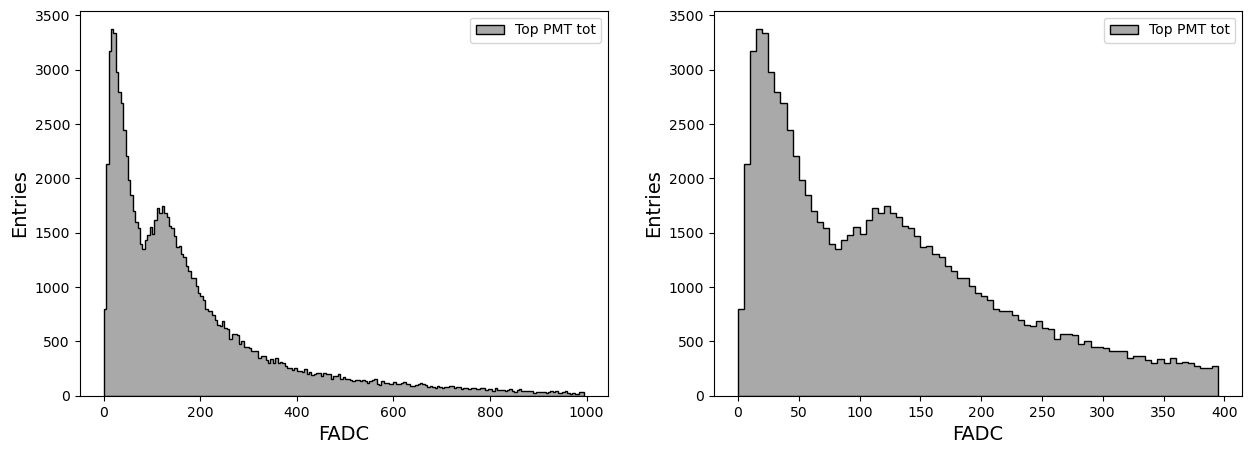

In [1171]:
input_folder = '/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/'
input_files = ['top_30cm_3', 'top_35cm_3', 'top_40cm_3', 'top_45cm_3', 'top_50cm_3', 'top_55cm_3', 'top_60cm_3', 'top_65cm_3','top_70cm_3']

min_npe = 10.

plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1)
fadc_bins = np.arange(0,1000,5)

pmt_tot = load_top_sum_fadc_pmt(input_folder+input_files[3])
#pmt_tot = load_pmt(input_folder+input_files[3],'pmt4_FADC',min_npe)[2]
plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
plt.legend()
plt.yscale('linear')
plt.xlabel('FADC',size=14)
plt.ylabel('Entries',size=14)


plt.subplot(1,2,2)
fadc_bins = np.arange(0,400,5)

plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
plt.legend()
plt.yscale('linear')
plt.xlabel('FADC',size=14)
plt.ylabel('Entries',size=14)


FADC bin with largest entries  120
First guess  [np.int64(169), np.float64(119.45462137154692), np.float64(68.95495940938386)]
Result of Gaussian fit
A = 157873.14042441576  +- 3789.368462271992
mu = 119.935270256924  +- 0.9259159506763712
sigma = 33.40748109507551  +- 0.925944316396542


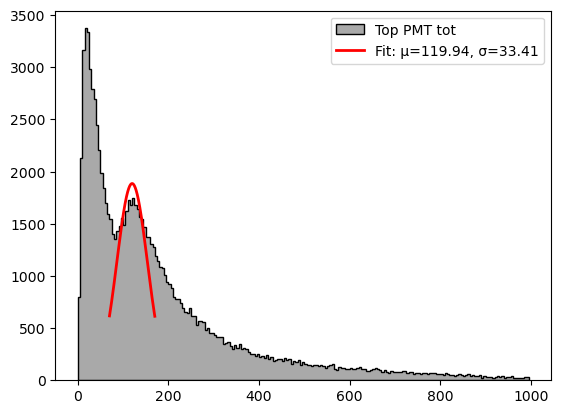

In [1172]:
fadc_bins_fit = np.arange(0,1000,5)

par, d_par, range = gaussian_fit(pmt_tot, fadc_bins_fit, range_low=50, range_hi=50, low_count_threshold=70)
A_fit, mu_fit, sigma_fit = par
A_err, mu_err, sigma_err = d_par

# Compute fitted curve
x_fit = np.linspace(range[0], range[1], 1000)
y_fit = gaussian(x_fit, *par)

print('Result of Gaussian fit')

print('A =',A_fit,' +-',A_err)
print('mu =',mu_fit,' +-',mu_err)
print('sigma =',sigma_fit,' +-',sigma_err)

plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
plt.plot(x_fit, y_fit, linewidth=2, label=f'Fit: μ={mu_fit:.2f}, σ={sigma_fit:.2f}',color='red')
plt.legend()

FADC bin with largest entries  50
First guess  [np.int64(89), np.float64(57.93441914985502), np.float64(40.29856151943798)]
Result of Gaussian fit
A = 341151.49844040436  +- 10332.456902622507
mu = 57.38543550457322  +- 0.6761369813958903
sigma = 19.338400683043464  +- 0.6766892377649104
Looking for minimum between  8  and  57.38543550457322
Found minimum at  20 

FADC bin with largest entries  60
First guess  [np.int64(99), np.float64(69.5937511287701), np.float64(41.46013205332665)]
Result of Gaussian fit
A = 293456.95927008265  +- 10087.34392573718
mu = 69.98775170649627  +- 0.8070644083884805
sigma = 20.334051453739388  +- 0.8071098761571499
Looking for minimum between  8  and  69.98775170649627
Found minimum at  40 

FADC bin with largest entries  90
First guess  [np.int64(134), np.float64(99.07736143637783), np.float64(48.14511861787637)]
Result of Gaussian fit
A = 269249.06622004916  +- 6562.771474351345
mu = 99.11129195839045  +- 0.6602254404320531
sigma = 23.458123546443172  +

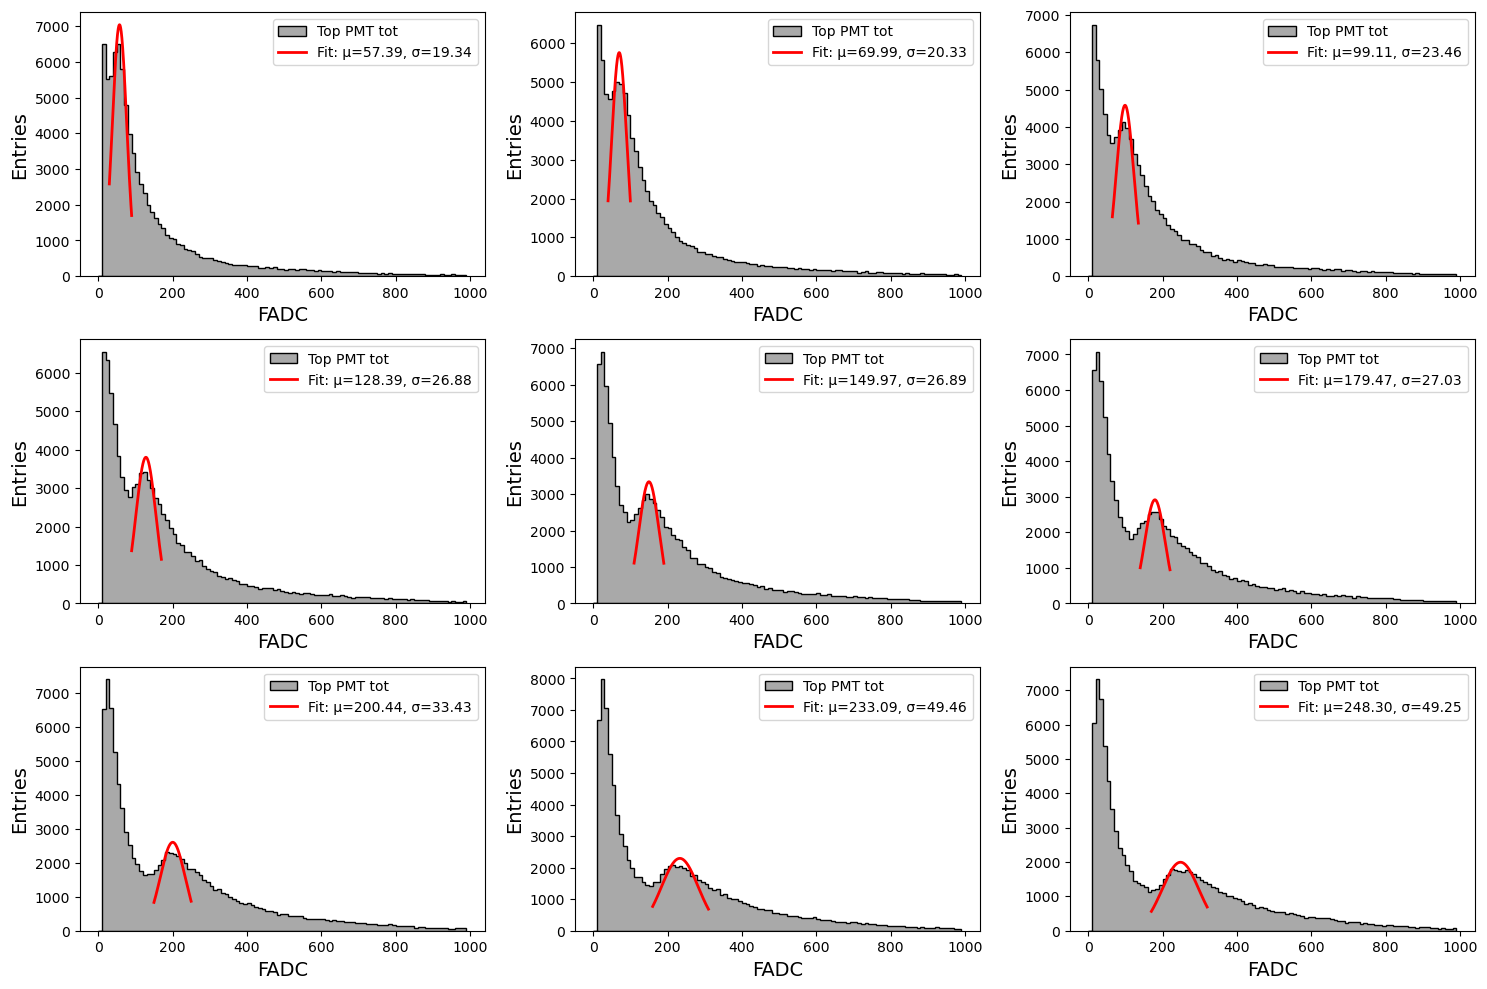

In [1173]:
plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,1000,FADC_BIN_WIDTH)
fadc_bin_centers = (fadc_bins_fit[:-1] + fadc_bins_fit[1:]) / 2.

low_count_threshold_array = [15, 40, 50, 70, 70, 100, 100, 100, 150]
low_count_threshold_array_min = [8, 8, 20, 20, 20, 20, 20, 20, 20]
range_width_low = [20, 20, 25, 30, 30, 30, 30, 50, 50]
range_width_hi = [40, 40, 45, 50, 50, 50, 70, 100, 100]

fadc_peak_bin = np.zeros(len(input_files))
rel_peak_err = np.zeros(len(input_files))
fadc_peak_entries = np.zeros(len(input_files))

fadc_min_bin = np.zeros(len(input_files))
fadc_min_entries = np.zeros(len(input_files))

for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_top_sum_fadc_pmt(input_folder+file, minnpe=10)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    par, d_par, range = gaussian_fit(pmt_tot, fadc_bins_fit, range_low=range_width_low[i], range_hi=range_width_hi[i], low_count_threshold=low_count_threshold_array[i])
    A_fit, mu_fit, sigma_fit = par
    A_err, mu_err, sigma_err = d_par

    # Compute fitted curve
    x_fit = np.linspace(range[0], range[1], 1000)
    y_fit = gaussian(x_fit, *par)

    print('Result of Gaussian fit')

    print('A =',A_fit,' +-',A_err)
    print('mu =',mu_fit,' +-',mu_err)
    print('sigma =',sigma_fit,' +-',sigma_err)

    rel_peak_err[i] = mu_err / mu_fit

    entries, bin, fig = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    plt.plot(x_fit, y_fit, linewidth=2, label=f'Fit: μ={mu_fit:.2f}, σ={sigma_fit:.2f}',color='red')
    plt.legend()
    plt.yscale('linear')
    plt.xlabel('FADC',size=14)
    plt.ylabel('Entries',size=14)

    fadc_peak_bin[i] = np.digitize(mu_fit, fadc_bins_fit) - 1
    fadc_peak_entries[i] = entries[np.digitize(mu_fit, fadc_bins_fit) - 1]

    fadc_min = find_valley(pmt_tot, low_threshold=low_count_threshold_array_min[i], peak_position=mu_fit)
    print('Found minimum at ',fadc_min,'\n')
    fadc_min_bin[i] = np.digitize(fadc_min, fadc_bins_fit) - 1
    fadc_min_entries[i] = entries[np.digitize(fadc_min, fadc_bins_fit) -1]


plt.tight_layout()


In [1174]:
print(fadc_peak_bin)
print(fadc_peak_entries)

[ 5.  6.  9. 12. 14. 17. 20. 23. 24.]
[6496. 5005. 4131. 3430. 3000. 2564. 2248. 2066. 1743.]


Max coordinates ( 55.0 ,  6496.0 )
Max coordinates ( 65.0 ,  5005.0 )
Max coordinates ( 95.0 ,  4131.0 )
Max coordinates ( 125.0 ,  3430.0 )
Max coordinates ( 145.0 ,  3000.0 )
Max coordinates ( 175.0 ,  2564.0 )
Max coordinates ( 205.0 ,  2248.0 )
Max coordinates ( 235.0 ,  2066.0 )
Max coordinates ( 245.0 ,  1743.0 )


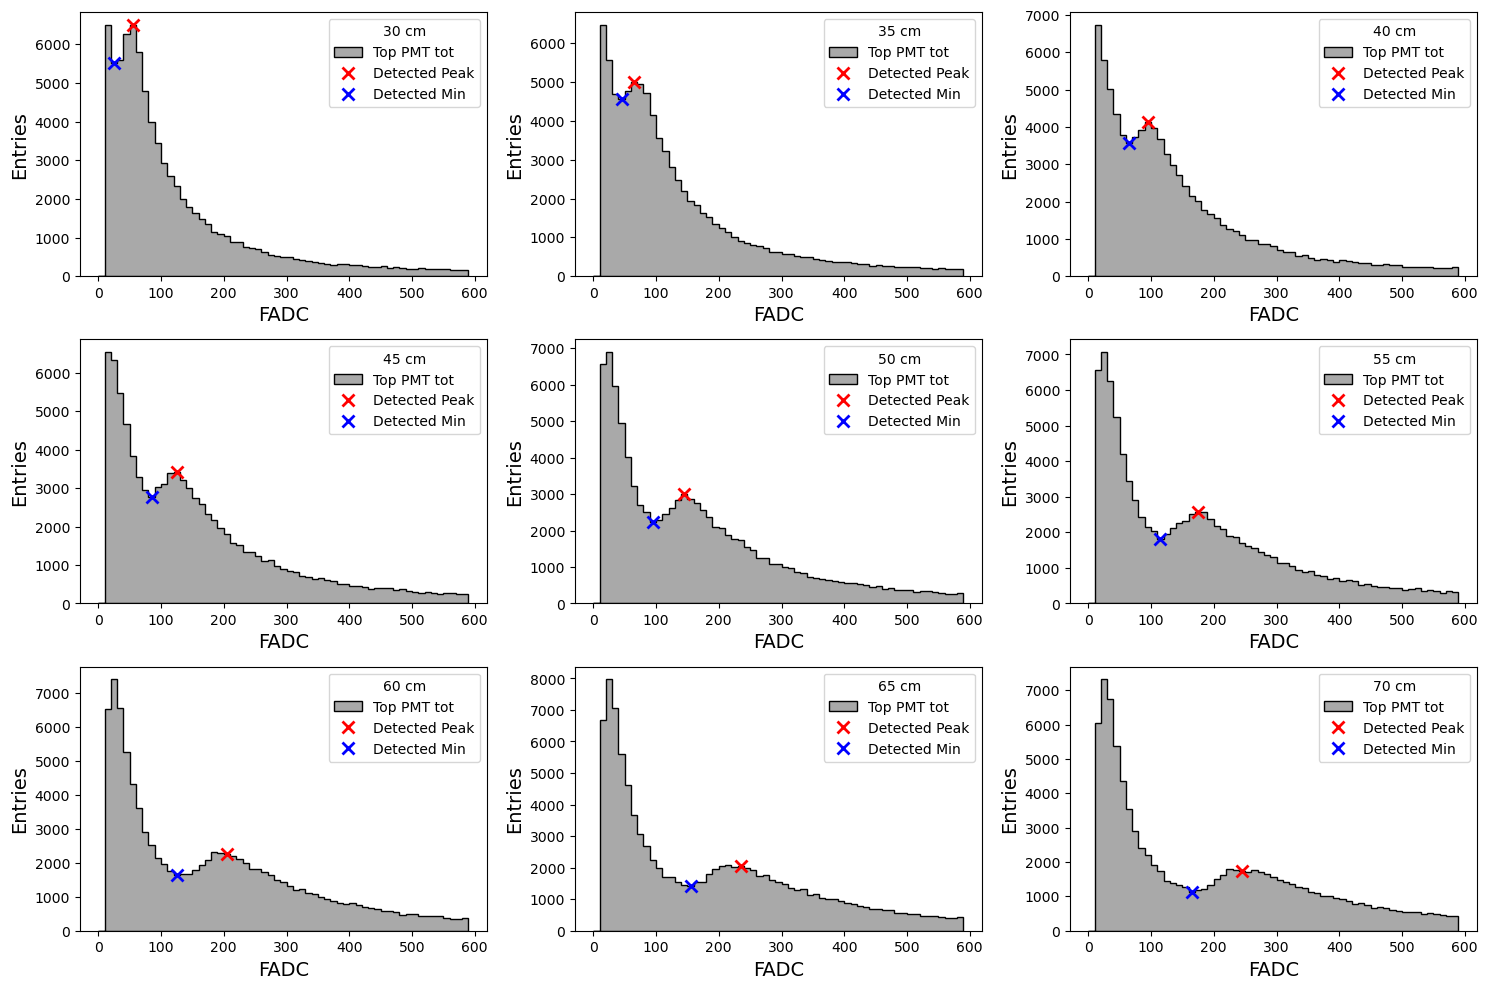

In [1175]:
plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,600,FADC_BIN_WIDTH)

leg_title = ['30 cm','35 cm','40 cm','45 cm','50 cm','55 cm','60 cm','65 cm','70 cm']

for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_top_sum_fadc_pmt(input_folder+file, minnpe=10)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    i_peak_bin = int(fadc_peak_bin[i])
    i_min_bin = int(fadc_min_bin[i])

    print('Max coordinates (',fadc_bin_centers[i_peak_bin],', ',fadc_peak_entries[i],')')
    entries, bin, fig = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    plt.plot(fadc_bin_centers[i_peak_bin], fadc_peak_entries[i], 'rx', label='Detected Peak', ms=8, mew=2)
    plt.plot(fadc_bin_centers[i_min_bin], fadc_min_entries[i], 'bx', label='Detected Min',ms=8, mew=2)

    plt.legend(title = leg_title[i])
    plt.yscale('linear')
    plt.xlabel('FADC',size=14)
    plt.ylabel('Entries',size=14)


plt.tight_layout()

plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/top_height_scan_max_min.pdf')

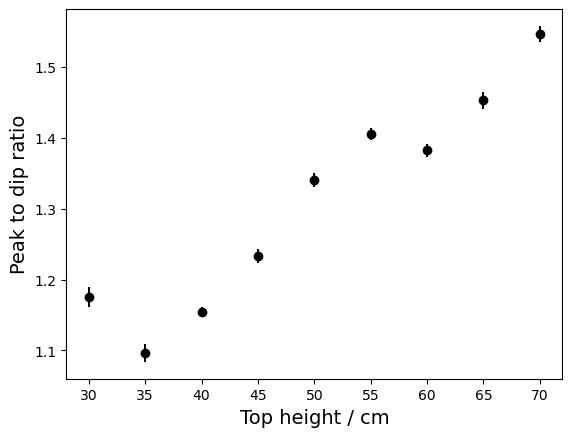

In [1176]:

top_height = np.arange(30,75,5)
ratio = fadc_peak_entries / fadc_min_entries

plt.errorbar(top_height, ratio, yerr = ratio * rel_peak_err, fmt='o',markerfacecolor='black', markeredgecolor='black', ecolor = 'black')
plt.xlabel('Top height / cm',size=14)
plt.ylabel('Peak to dip ratio',size=14)

plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/top_height_scan_peak_dip_ratio.pdf')